In [1]:
import requests
import json
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

# Load Data

In [92]:
# load data
all_df = pd.read_pickle("issues.pkl")

# convert datat time to correct format
all_df["created_at"] = pd.to_datetime(all_df["created_at"])
all_df["closed_at"] = pd.to_datetime(all_df["closed_at"])

# choose only issues that are after 01/01/2020
all_df = all_df[all_df["created_at"] >= "2020-01-01"]

# Some Basic Questions

In [97]:
# how many issues there are?

all_df.shape

(9942, 27)

In [98]:
# what information/columns are available?

all_df.columns

Index(['active_lock_reason', 'assignee', 'assignees', 'author_association',
       'body', 'closed_at', 'closed_by', 'comments', 'comments_url',
       'created_at', 'events_url', 'html_url', 'id', 'labels', 'labels_url',
       'locked', 'milestone', 'node_id', 'number', 'performed_via_github_app',
       'pull_request', 'repository_url', 'state', 'title', 'updated_at', 'url',
       'user'],
      dtype='object')

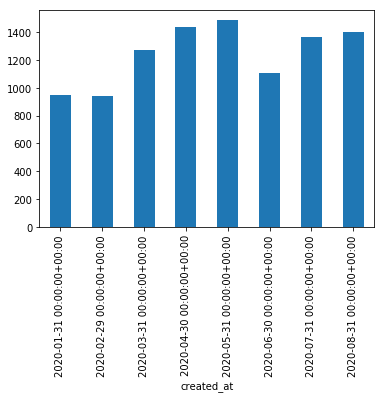

In [95]:
# how do the number of issues change month over month?

all_df.set_index("created_at").resample("M").count()["number"].plot.bar()

In [96]:
# how long does it take to close an

tmp = all_df[all_df["state"] == "closed"].copy(deep=True)
tmp["time_to_close"] = tmp["closed_at"] - tmp["created_at"]
tmp = tmp.set_index("created_at")#.resample("M")
pd.concat([tmp[["time_to_close"]].agg(lambda x: x.median()).rename(columns={"time_to_close": "median"}),
           tmp[["time_to_close"]].agg(lambda x: x.mean()).rename(columns={"time_to_close": "mean"}),
           tmp[["time_to_close"]].agg(lambda x: x.max()).rename(columns={"time_to_close": "max"}),
           tmp[["time_to_close"]].count().rename(columns={"time_to_close": "count"}),], axis=1)

,0,1,2,3
time_to_close,2 days 04:54:31,11 days 19:37:29.479677,218 days 15:06:52,8193


In [12]:
# which issue takes the longest to close?

tmp[tmp["time_to_close"] == tmp["time_to_close"].max()]

,active_lock_reason,assignee,assignees,author_association,body,closed_at,closed_by,comments,comments_url,events_url,...,number,performed_via_github_app,pull_request,repository_url,state,title,updated_at,url,user,time_to_close
created_at,,,,,,,,,,,,,,,,,,,,,
2020-01-20 18:26:20+00:00,None,None,[],MEMBER,This issue was autofiled by Sentry. It represe...,2020-08-26 09:33:12+00:00,"{'login': 'tbg', 'id': 5076964, 'node_id': 'MD...",0,https://api.github.com/repos/cockroachdb/cockr...,https://api.github.com/repos/cockroachdb/cockr...,...,44139,None,None,https://api.github.com/repos/cockroachdb/cockr...,closed,storage: v19.2.2: nil pointer dereference,2020-08-26T09:33:12Z,https://api.github.com/repos/cockroachdb/cockr...,"{'login': 'cockroach-teamcity', 'id': 20559710...",218 days 15:06:52


In [99]:
# what are the breakdown author_association for each issue

tmp = all_df.groupby("author_association")["number"].count()
tmp / tmp.sum()

author_association
COLLABORATOR    0.101790
CONTRIBUTOR     0.274693
MEMBER          0.566888
NONE            0.056628
Name: number, dtype: float64

# Focusing on Labels

In [101]:
# how many unique labels are there

unique_labels = set()

for x in all_df["labels"]:
    for y in x:
        unique_labels.add(y["name"])

len(unique_labels)

192

In [103]:
# what are the median nunmber of labels associated with each issue

all_df["labels"].apply(lambda x: len(x)).median()

1.0

In [102]:
# what are the average nunmber of labels associated with each issue

all_df["labels"].apply(lambda x: len(x)).mean()

1.532387849527258

In [104]:
# what are the top 10 issues?

tmp = all_df.copy(deep=True)

labels = {}
description = {}

for x in tmp["labels"]:
    for y in x:
        if y["name"] in labels:
            labels[y["name"]][1] += 1
        else:
            labels[y["name"]] = [y["description"], 1]
            description[y["name"]] = y["description"]

pd.set_option('display.max_colwidth', 100)
tmp = pd.DataFrame(labels).T.sort_values(by=1, ascending=False).iloc[:10].fillna("")
tmp.columns = ["label_description", "frequency"]
tmp.frequency = tmp.frequency.astype(int)
tmp

,label_description,frequency
C-test-failure,Broken test (automatically or manually discovered).,2029
O-robot,Originated from a bot.,1981
O-roachtest,,1509
release-blocker,,1419
C-bug,"Code not up to spec/doc, specs & docs deemed correct. Solution expected to change code/behavior.",1197
C-enhancement,Solution expected to add code/behavior + preserve backward-compat (pg compat issues are exception),1024
branch-master,Failures on the master branch.,927
O-sentry,Originated from an in-the-wild panic report.,528
O-community,Originated from the community,315
A-geometry-builtins,Builtins which have geometry as args.,219


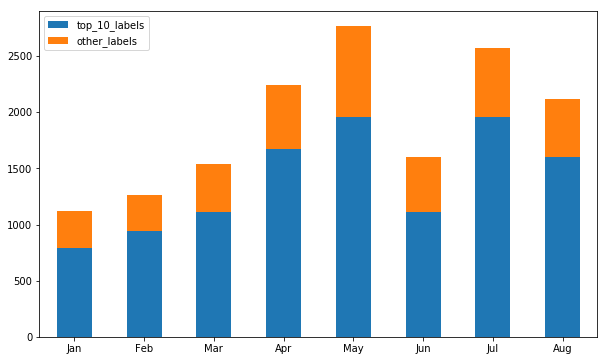

In [105]:
# how do these top issues evolve over time

tmp = all_df.copy(deep=True)
tmp["month"] = tmp["created_at"].apply(lambda x: x.month)

label_freq_dict = {}

top_10_labels = ["C-test-failure", "O-robot", "O-roachtest", "release-blocker", "C-bug",
                 "C-enhancement", "branch-master", "O-sentry", "O-community", "A-geometry-builtins"]

for month in range(1, 9):
    
    labels = {
        "top_10_labels":0,
        "other_labels":0
    }
    
    for x in tmp[tmp["month"] == month]["labels"]:
        for y in x:
            if y["name"] in top_10_labels:
                labels["top_10_labels"] += 1
            else:
                labels["other_labels"] += 1
    
    label_freq_dict[month] = labels
    

tmp = pd.DataFrame(label_freq_dict).T
tmp.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
tmp = tmp[["top_10_labels", "other_labels"]]

tmp.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)

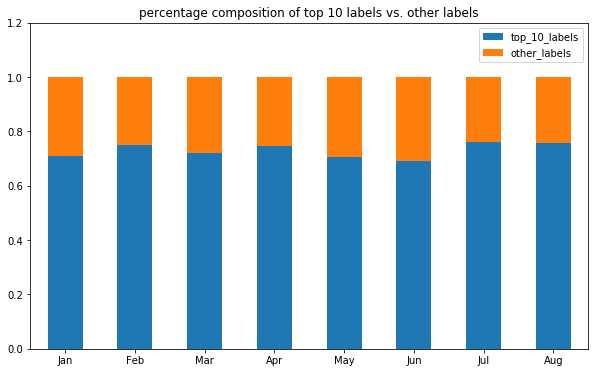

In [106]:
# what if we view the above from the perspective of percentage

tmp = pd.concat([tmp["top_10_labels"] / tmp.sum(axis=1),
                 tmp["other_labels"] / tmp.sum(axis=1)], axis=1)

tmp.columns = ["top_10_labels", "other_labels"]

tmp.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0, ylim=(0, 1.2), title="percentage composition of top 10 labels vs. other labels")

In [108]:
# what are the correlation between the top issues

tmp = all_df.copy(deep=True)

labels = {
    "C-test-failure":[],
    "O-robot":[],
    "O-roachtest":[],
    "release-blocker":[],
    "C-bug":[],
    "C-enhancement":[],
    "branch-master":[],
    "O-sentry":[],
    "O-community":[],
    "A-geometry-builtins":[],
}

index = []

for i, row in tmp.iterrows():
    index.append(row["number"])
    
    row_labels = []    
    for x in row["labels"]:
        row_labels.append(x["name"])
        
    for x in labels.keys():
        if x in row_labels:
            labels[x].append(1)
        else:
            labels[x].append(0)
            
pd.DataFrame(labels, index=index).corr()

,C-test-failure,O-robot,O-roachtest,release-blocker,C-bug,C-enhancement,branch-master,O-sentry,O-community,A-geometry-builtins
C-test-failure,1.000000,0.985117,0.834683,0.797233,-0.182742,-0.171588,0.633267,-0.119922,-0.090172,-0.075996
O-robot,0.985117,1.000000,0.845893,0.809330,-0.183781,-0.169034,0.640236,-0.118138,-0.090234,-0.074865
O-roachtest,0.834683,0.845893,1.000000,0.953367,-0.153918,-0.143341,0.372426,-0.100181,-0.076518,-0.063486
release-blocker,0.797233,0.809330,0.953367,1.000000,-0.145658,-0.138265,0.340874,-0.096633,-0.073808,-0.061237
C-bug,-0.182742,-0.183781,-0.153918,-0.145658,1.000000,-0.124350,-0.117575,0.640122,0.095420,-0.053419
C-enhancement,-0.171588,-0.169034,-0.143341,-0.138265,-0.124350,1.000000,-0.108661,-0.080250,-0.015953,0.440645
branch-master,0.633267,0.640236,0.372426,0.340874,-0.117575,-0.108661,1.000000,-0.075943,-0.058005,-0.048126
O-sentry,-0.119922,-0.118138,-0.100181,-0.096633,0.640122,-0.080250,-0.075943,1.000000,-0.042839,-0.035543
O-community,-0.090172,-0.090234,-0.076518,-0.073808,0.095420,-0.015953,-0.058005,-0.042839,1.000000,-0.027148
A-geometry-builtins,-0.075996,-0.074865,-0.063486,-0.061237,-0.053419,0.440645,-0.048126,-0.035543,-0.027148,1.000000


In [112]:
# what are the top labels for each month

tmp = all_df.copy(deep=True)
tmp["month"] = tmp["created_at"].apply(lambda x: x.month)

label_freq_dict = {}

for month in range(1, 9):
    labels = {}
    
    for x in tmp[tmp["month"] == month]["labels"]:
        for y in x:
            if y["name"] in labels:
                labels[y["name"]][1] += 1
            else:
                labels[y["name"]] = [y["description"], 1]
    
    
    label_freq_dict[month] = pd.DataFrame(labels).T.sort_values(by=1, ascending=False).iloc[:20].index
    
pd.DataFrame(label_freq_dict)

,1,2,3,4,5,6,7,8
0,C-test-failure,C-test-failure,C-test-failure,C-test-failure,C-enhancement,C-test-failure,C-test-failure,C-test-failure
1,C-bug,O-robot,O-robot,O-robot,C-test-failure,C-bug,O-robot,O-robot
2,O-robot,O-roachtest,release-blocker,O-roachtest,O-robot,O-robot,O-roachtest,C-bug
3,O-roachtest,release-blocker,O-roachtest,release-blocker,A-geometry-builtins,C-enhancement,release-blocker,O-roachtest
4,O-sentry,C-bug,C-bug,C-bug,O-roachtest,O-roachtest,branch-master,release-blocker
5,branch-master,branch-master,branch-master,branch-master,release-blocker,release-blocker,C-bug,branch-master
6,release-blocker,O-sentry,C-enhancement,C-enhancement,C-bug,O-sentry,C-enhancement,C-enhancement
7,C-enhancement,C-enhancement,O-sentry,branch-provisional_202004210018_v20.1.0,E-easy,branch-master,O-community,O-sentry
8,A-telemetry,A-webui-general,A-bulkio,branch-release-20.1,branch-master,O-community,O-sentry,A-bulkio
9,branch-release-19.2,branch-release-19.2,backport-19.2.x,A-multitenancy,O-sentry,X-blathers-triaged,C-cleanup,O-community


In [113]:
# what are the counts for the above?

tmp = all_df.copy(deep=True)
tmp["month"] = tmp["created_at"].apply(lambda x: x.month)

label_freq_dict = {}

for month in range(1, 9):
    labels = {}
    
    for x in tmp[tmp["month"] == month]["labels"]:
        for y in x:
            if "branch-" in y["name"]:
                continue
            elif y["name"] in labels:
                labels[y["name"]][1] += 1
            else:
                labels[y["name"]] = [y["description"], 1]
    
    label_freq_dict[month] = pd.DataFrame(labels).T.sort_values(by=1, ascending=False).iloc[:20][1].to_dict()

label_freq_dict

{1: {'C-test-failure': 147,
  'C-bug': 144,
  'O-robot': 144,
  'O-roachtest': 114,
  'O-sentry': 70,
  'release-blocker': 52.0,
  'C-enhancement': 51,
  'A-telemetry': 19,
  'backport-19.2.x': 15,
  'C-investigation': 14,
  'A-security': 11,
  'A-cli': 10,
  'C-cleanup': 10,
  'S-3-ux-surprise': 9,
  'A-webui-general': 9,
  'A-kv': 8,
  'A-sql-pgcompat': 8,
  'A-bulkio': 7,
  'O-sqlsmith': 7,
  'O-community': 7},
 2: {'C-test-failure': 198,
  'O-robot': 193,
  'O-roachtest': 145,
  'release-blocker': 128.0,
  'C-bug': 92,
  'O-sentry': 46,
  'C-enhancement': 46,
  'A-webui-general': 23,
  'backport-19.2.x': 16,
  'A-sql-pgcompat': 14,
  'A-webui': 12,
  'A-bulkio': 11,
  'C-investigation': 11,
  'A-webui-queryperf': 10,
  'docs-todo': 10,
  'O-community': 9,
  'A-webui-databases': 8,
  'A-telemetry': 8,
  'A-jobs': 8,
  'A-schema-changes': 7},
 3: {'C-test-failure': 229,
  'O-robot': 225,
  'release-blocker': 157.0,
  'O-roachtest': 153,
  'C-bug': 116,
  'C-enhancement': 71,
  'O-sen

{1: {'C-test-failure': 147,
  'C-bug': 144,
  'O-robot': 144,
  'O-roachtest': 114,
  'O-sentry': 70,
  'release-blocker': 52.0,
  'C-enhancement': 51,
  'A-telemetry': 19,
  'backport-19.2.x': 15,
  'C-investigation': 14,
  'A-security': 11,
  'A-cli': 10,
  'C-cleanup': 10,
  'S-3-ux-surprise': 9,
  'A-webui-general': 9,
  'A-kv': 8,
  'A-sql-pgcompat': 8,
  'A-bulkio': 7,
  'O-sqlsmith': 7,
  'O-community': 7},
 2: {'C-test-failure': 198,
  'O-robot': 193,
  'O-roachtest': 145,
  'release-blocker': 128.0,
  'C-bug': 92,
  'O-sentry': 46,
  'C-enhancement': 46,
  'A-webui-general': 23,
  'backport-19.2.x': 16,
  'A-sql-pgcompat': 14,
  'A-webui': 12,
  'A-bulkio': 11,
  'C-investigation': 11,
  'A-webui-queryperf': 10,
  'docs-todo': 10,
  'O-community': 9,
  'A-webui-databases': 8,
  'A-telemetry': 8,
  'A-jobs': 8,
  'A-schema-changes': 7},
 3: {'C-test-failure': 229,
  'O-robot': 225,
  'release-blocker': 157.0,
  'O-roachtest': 153,
  'C-bug': 116,
  'C-enhancement': 71,
  'O-sen

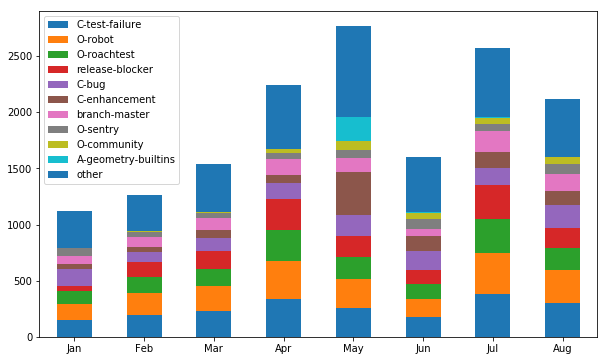

In [114]:
# how does the composition evolve over time?

tmp = all_df.copy(deep=True)
tmp["month"] = tmp["created_at"].apply(lambda x: x.month)

label_freq_dict = {}

for month in range(1, 9):
    
    labels = {
        "C-test-failure":0,
        "O-robot":0,
        "O-roachtest":0,
        "release-blocker":0,
        "C-bug":0,
        "C-enhancement":0,
        "branch-master":0,
        "O-sentry":0,
        "O-community":0,
        "A-geometry-builtins":0,
        "other":0
    }
    
    for x in tmp[tmp["month"] == month]["labels"]:
        for y in x:
            if y["name"] in labels:
                labels[y["name"]] += 1
            else:
                labels["other"] += 1
    
    label_freq_dict[month] = labels
    

tmp = pd.DataFrame(label_freq_dict).T
tmp.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
tmp = tmp[["C-test-failure", "O-robot", "O-roachtest", "release-blocker",
           "C-bug", "C-enhancement", "branch-master", "O-sentry", "O-community",
           "A-geometry-builtins", "other"]]

tmp.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)

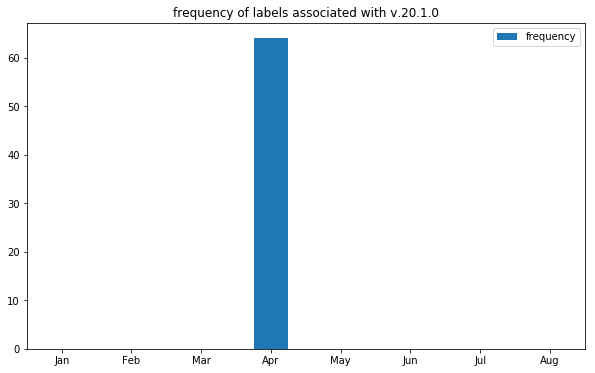

In [38]:
tmp = all_df.copy(deep=True)
tmp["month"] = tmp["created_at"].apply(lambda x: x.month)

label_freq_dict = {}

for month in range(1, 9):
    
    labels = {
    }
    
    for x in tmp[tmp["month"] == month]["labels"]:
        for y in x:
    
    label_freq_dict[month] = labels
    

tmp = pd.DataFrame(label_freq_dict).T
tmp.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
tmp.columns = ["frequency"]

tmp.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0, title = "frequency of labels associated with v.20.1.0")

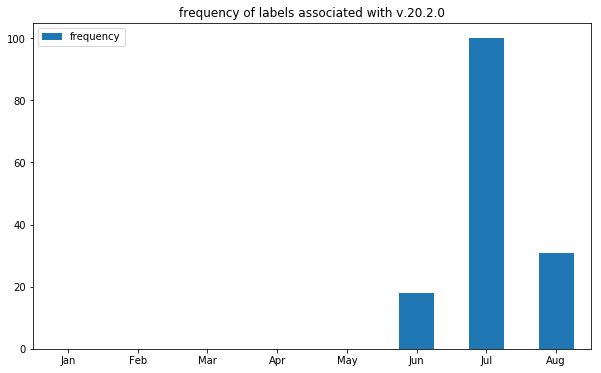

In [39]:
tmp = all_df.copy(deep=True)
tmp["month"] = tmp["created_at"].apply(lambda x: x.month)

label_freq_dict = {}

for month in range(1, 9):
    
    labels = {
        "20.2.0":0,
    }
    
    for x in tmp[tmp["month"] == month]["labels"]:
        for y in x:
            if "20.2.0" in y["name"]:
                labels["20.2.0"] +=1
    
    label_freq_dict[month] = labels
    

tmp = pd.DataFrame(label_freq_dict).T
tmp.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
tmp.columns = ["frequency"]

tmp.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0, title = "frequency of labels associated with v.20.2.0")

In [ ]:
# check word frequency in title

In [ ]:
# get stopword list to be eliminated

import nltk

nltk.download('stopwords')
stopwords = list(stopwords.words('english'))

In [143]:
# set up function to weed out stopwords

def freq(str):

    # break the string into list of words 
    str_list = str.split() 
  
    # gives set of unique words 
    unique_words = set(str_list) 
      
    freq_dict = {}
    
    for words in unique_words:
        if words not in stopwords:
#             print('Frequency of ', words , 'is :', str_list.count(words))
            freq_dict[words] = str_list.count(words)
    
    return freq_dict

In [144]:
# run function on issue titles

title = " ".join(all_df["title"].to_list())

freq_dict = freq(title)

In [147]:
# what are the top 50 words that are mentioned most frequently

pd.DataFrame(freq_dict, index=["frequency"]).T.sort_values(by=["frequency"], ascending=False).iloc[:50]

,frequency
failed,1984
roachtest:,1729
sql:,1688
add,806
fix,722
opt:,506
implement,418
ui:,415
sentry:,341
error,334


In [148]:
# what about month over month?

tmp = all_df.copy(deep=True)
tmp["month"] = tmp["created_at"].apply(lambda x: x.month)

freq_dict = {}

for month in range(1, 9):
    title = " ".join(tmp[tmp["month"] == month]["title"].to_list())

    freq_dict[month] = pd.DataFrame(freq(title), index=[0]).T.sort_values(by=[0], ascending=False).iloc[:20].to_dict()[0]    

In [149]:
freq_dict

{1: {'failed': 145,
  'sql:': 144,
  'roachtest:': 141,
  'fix': 99,
  'add': 78,
  'sentry:': 53,
  'error': 53,
  'colexec:': 47,
  'storage:': 47,
  'release-19.2:': 44,
  'data': 41,
  'key': 39,
  'opt:': 39,
  'ui:': 38,
  'payloads)': 34,
  '(2)': 34,
  'extra': 34,
  '*withstack.withStack': 34,
  '*assert.withAssertionFailure': 34,
  '(1)': 34},
 2: {'failed': 195,
  'roachtest:': 163,
  'sql:': 144,
  'ui:': 102,
  'fix': 76,
  'add': 70,
  'colexec:': 59,
  'error': 42,
  'key': 34,
  'table': 34,
  'release-19.2:': 32,
  'opt:': 31,
  'page': 31,
  'test': 27,
  'primary': 27,
  'jobs:': 24,
  'type': 23,
  'make': 22,
  'storage:': 22,
  'list': 20},
 3: {'sql:': 260,
  'failed': 229,
  'roachtest:': 170,
  'add': 120,
  'ui:': 118,
  'fix': 113,
  'colexec:': 80,
  'error': 65,
  'opt:': 62,
  'release-19.2:': 49,
  'support': 43,
  'page': 41,
  'table': 40,
  'change': 34,
  'test': 32,
  'key': 30,
  'schema': 28,
  'telemetry': 28,
  'kv:': 26,
  'primary': 26},
 4: {'